Загружаем данные...
Обрабатываем данные...
Index(['user_id', 'item_id', 'timespent', 'like', 'dislike', 'share',
       'bookmarks', 'source_id', 'duration', 'gender', 'age', 'user_activity',
       'views', 'total_likes', 'total_shares', 'total_bookmarks',
       'total_timespent', 'avg_timespent_per_view', 'activity_score',
       'item_ctr', 'engagement_ratio', 'timespent_to_user_avg_duration'],
      dtype='object')
Матрица корреляций: 


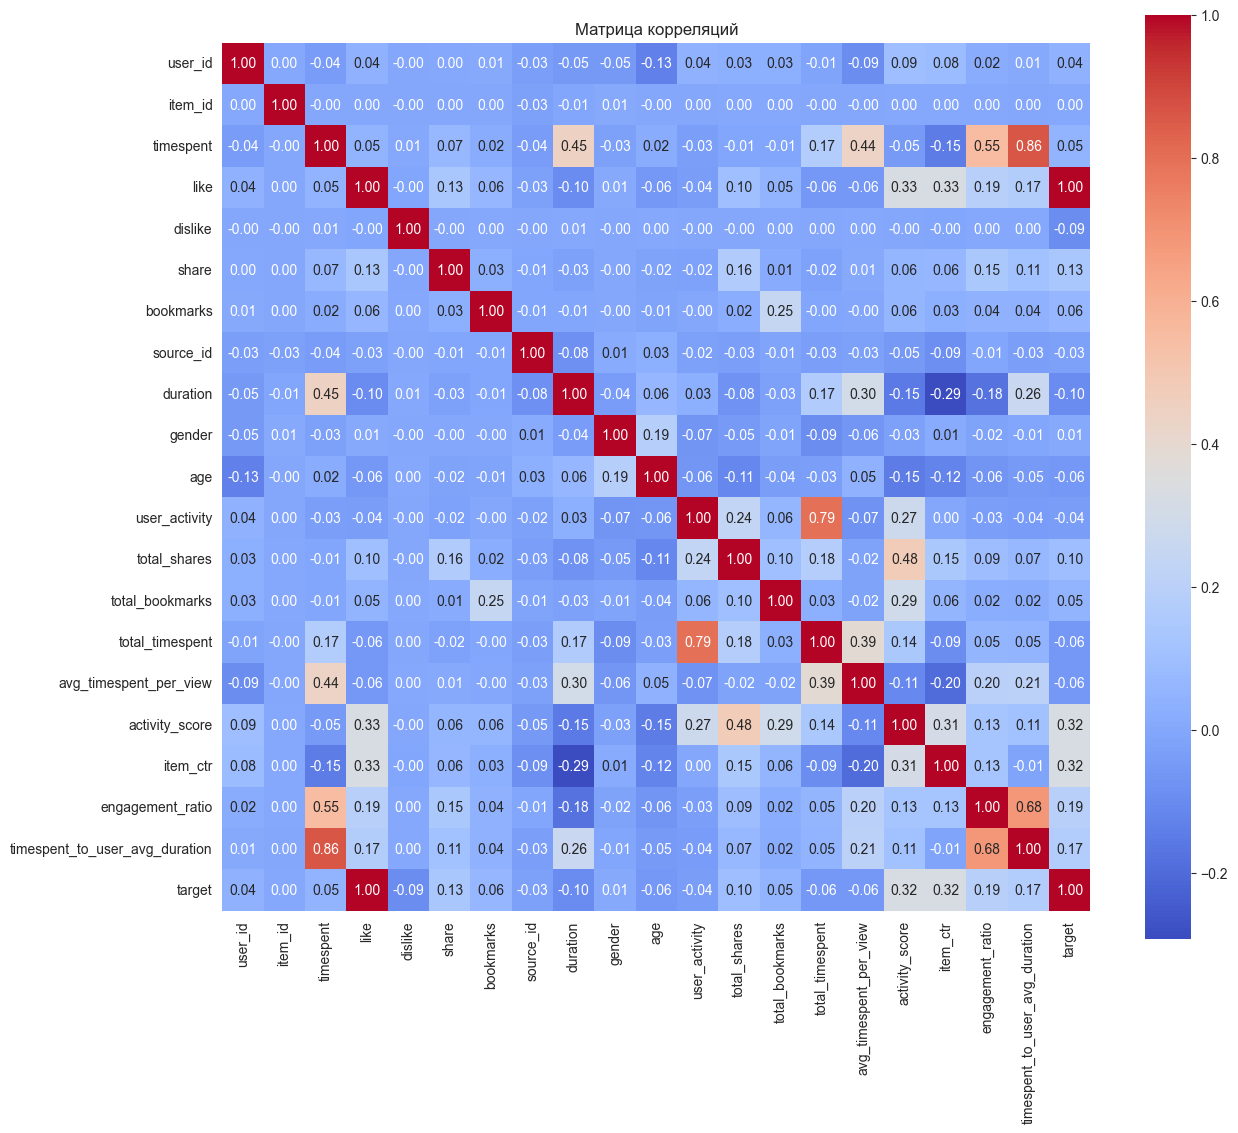

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from custom_roc_auc import custom_roc_auc
from catboost import CatBoostRanker, Pool
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

file_path_train_interactions = "../data/train_interactions.parquet"
file_path_users_meta = "../data/users_meta.parquet.parquet"
file_path_items_meta = "../data/items_meta.parquet.parquet"
file_path_test_pair = "../data/test_pairs.csv.csv"

print("Загружаем данные...")
train = pd.read_parquet(file_path_train_interactions)
# Первые N строк
N = 10_000_000
train = train.head(N)

print("Обрабатываем данные...")
train_i = pd.read_parquet(file_path_items_meta)
train_u = pd.read_parquet(file_path_users_meta)
train_i = train_i.drop(columns='embeddings', errors='ignore')
train = train.merge(train_i, how='left', on='item_id', sort=False)
train = train.merge(train_u, how='left', on='user_id', sort=False)
# Генерация новых фичей:
# Фича активности пользователя
user_activity = train.groupby('user_id').size().rename('user_activity')
train = train.merge(user_activity, on='user_id', how='left')

# Фича: Насколько пользователь активен
user_stats = train.groupby('user_id').agg(
    views=('item_id', 'count'),
    total_likes=('like', 'sum'),
    total_shares=('share', 'sum'),
    total_bookmarks=('bookmarks', 'sum'),
    total_timespent=('timespent', 'sum')
).reset_index()

# Можно добавить еще производные признаки:
user_stats['avg_timespent_per_view'] = user_stats['total_timespent'] / user_stats['views']
user_stats['activity_score'] = user_stats[['total_likes', 'total_shares', 'total_bookmarks']].sum(axis=1)

train = train.merge(user_stats, on='user_id', how='left')
#

# Средняя кликабельность пользователя
item_stats = train.groupby('item_id').agg(
    item_views=('user_id', 'count'),
    item_likes=('like', 'sum')
).reset_index()

item_stats['item_ctr'] = item_stats['item_likes'] / item_stats['item_views']

train = train.merge(item_stats[['item_id', 'item_ctr']], on='item_id', how='left')
#

# Фича показывающая процент просмотра ролика для пользователя
train['engagement_ratio'] = train['timespent'] / train['duration']
avg_duration = train.groupby('user_id')['duration'].transform('mean')
# Фича отношение времени к средней длительности ролика
train['timespent_to_user_avg_duration'] = train['timespent'] / avg_duration

print(train.columns)
df = train.copy()  # Создаем копию, чтобы не изменять исходный DataFrame
df['target'] = df['like'].astype('int32') - df['dislike']

df.drop(columns=['views', 'total_likes'], inplace=True)

# Промежуточный вывод
# print(df['target'].value_counts())
correlation_matrix = df.corr(numeric_only=True)  # учитываем только числовые столбцы
print('Матрица корреляций: ')
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Матрица корреляций")
plt.show()

features = ['timespent','share','bookmarks','source_id', 'duration',
            'age', 'engagement_ratio']

# features = df.columns
# train.drop(columns='views', inplace=True).drop(columns='timespent', inplace=True)

user_ids = df['user_id'].values
X = df[features]
y = df['target'].values

X_train, X_test, y_train, y_test, user_ids_train, user_ids_test =\
    train_test_split(X, y, user_ids, test_size=0.2, random_state=42)

## Магия с метрикой

In [8]:
class ROCAUC:
    def __init__(self, group_indices):
        self.group_indices = group_indices

    def evaluate(self, approxes, target, weight):
        y_pred = np.array(approxes[0])
        y_true = np.array(target)
        auc = custom_roc_auc(y_pred, y_true, self.group_indices)
        return auc, 0

    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def get_description(self):
        return 'ROCAUC'

In [9]:
group_indices = train['user_id'].value_counts().sort_index().values
metric = ROCAUC(group_indices=group_indices)

## Работа с данных

### IQR

In [53]:
numerical_features = ['timespent'] #'timespent', 'duration', 'age', 'engagement_ratio'
# plt.figure(figsize=(18, 15))
# for i, feature in enumerate(numerical_features):
#     plt.subplot(3, 2, i+1)
#     sns.boxplot(x=X_train[feature])
#     plt.title(f'Боксплот признака {feature}')
# plt.tight_layout()
# plt.show()

In [54]:
def remove_iqr(df, columns):
    df_filter = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q2 = df[column].quantile(0.75)
        IQR = Q2 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q2 + 1.5 * IQR
        df_filter[column] = df[column].between(lower, upper)
    return df_filter

X_filter = remove_iqr(X_train, numerical_features)

После IQR, единственный вклад в модель внесла 'timespent'.<br>
'duration', age', 'engagement_ratio' при удалении выбросов сделали только хуже, либо оставили все как есть.
<br>
Влияние удаление на оценку 0.00049.<br>
0.7455735873070776 с IQR<br>
0.7450775640706507 без IQR<br>
Хотя на большой выборке виден небольшой откат<br>
0.7489764626973074 c IQR<br>
0.748980051357803 буз IQR


In [83]:
print(0.7455735873070776 - 0.7450775640706507)
print(0.7489764626973074 - 0.748980051357803)

0.0004960232364268347
-3.588660495545959e-06


### Объединение признаков

get_feature_importance толком ничего не показывает, выдаёт 95 процентную важность engagment-а, и на сдачу share<br>

In [84]:
np.allclose(df['engagement_ratio'], df['timespent'] / df['duration'])

True

In [85]:
model.get_feature_importance(train_pool, type='PredictionValuesChange')  # ещё один популярный способ


CatBoostError: Feature importance type EFstrType.LossFunctionChange requires training dataset                             to be passed to this function.

### Добавление фичей

Добавил timespent_to_avg_duration_ratio — отношение времени к средней длительности. Точность возрасла незначительно, но всё лучше. На полном датасете не тестировал.<br>
is_fully_watched только ухучшил модель.<br>
Пока непонятно оставлять ли новую фичу, так как вместе с IQR результат хуже, чем без него. Получается, что лучще использовать, что то одно, лучший вариант - это фича без IQR, но разность между ними смешная.(0.7473162023012448 - лучший результат)



##

In [55]:
# Формирование таргета и фичей. Разбивка датасета.
# user_ids - массив со всеми уникальными пользователями.

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
# user_ids_train
# Группировка и сортировка данных для CatBoost
# Временные переменные

X = X_train
y = y_train
group_id = user_ids_train

# Сортировка по user_id
sorted_idx = np.argsort(group_id)
X = X.iloc[sorted_idx].reset_index(drop=True)
y = np.array(y)[sorted_idx]
group_id = np.array(group_id)[sorted_idx]

# group_sizes - массив, содержащий кол-во объектов в каждой группе.
# То есть, количество роликов у каждого пользователя
group_sizes = (
    pd.Series(group_id)
    .value_counts()
    .sort_index()
    .values
) # Random forest
model = CatBoostRanker(
    loss_function='YetiRank',
    task_type='CPU',
    iterations=1,
    reg_lambda=24,
    depth=7,
    min_child_samples=1,
    random_state=17,
    learning_rate=0.03,
    early_stopping_rounds=100,
    verbose=20,
    eval_metric=metric
)

model.fit(
    X, y,
    group_id=group_id
)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("Roc Auc Train: ", custom_roc_auc(y_pred_train, y_train, group_sizes))
print("Roc Auc Test:  ",custom_roc_auc(y_pred_test, y_test, group_sizes))


C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\catboost\core.py:2321: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


0:	learn: 0.7360042	total: 4.59s	remaining: 0us
Roc Auc Train:  0.7264496431182759
Roc Auc Test:   0.7255287694858417


In [68]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def compute_group_metrics(y_pred, y_true, group_indices, k=10):
    n_groups = len(group_indices) - 1
    precision_list = np.empty(n_groups)
    recall_list = np.empty(n_groups)
    ap_list = np.empty(n_groups)

    for g in prange(n_groups):
        start = group_indices[g]
        end = group_indices[g + 1]
        p = y_pred[start:end]
        t = y_true[start:end]

        if len(p) == 0:
            precision_list[g] = np.nan
            recall_list[g] = np.nan
            ap_list[g] = np.nan
            continue

        sorted_idx = np.argsort(-p)
        sorted_true = t[sorted_idx]

        hits = 0
        sum_precisions = 0.0
        true_positives = np.sum(t == 1)
        max_k = min(k, len(t))

        for i in range(max_k):
            if sorted_true[i] == 1:
                hits += 1
                sum_precisions += hits / (i + 1)

        precision_at_k = hits / max_k
        recall_at_k = hits / true_positives if true_positives > 0 else np.nan
        map_at_k = sum_precisions / min(true_positives, k) if true_positives > 0 else np.nan

        precision_list[g] = precision_at_k
        recall_list[g] = recall_at_k
        ap_list[g] = map_at_k

    return precision_list, recall_list, ap_list


def compute_all_metrics(y_pred, y_true, group_sizes, k=10):
    group_indices = np.cumsum(np.concatenate(([0], group_sizes)))
    precision, recall, ap = compute_group_metrics(y_pred, y_true, group_indices, k)

    return {
        f"Precision@{k}": np.nanmean(precision),
        f"Recall@{k}": np.nanmean(recall),
        f"MAP@{k}": np.nanmean(ap)
    }


In [70]:
metrics = compute_all_metrics(y_pred_test, y_test, group_sizes, k=10)

for name, score in metrics.items():
    print(f"{name}: {score:.4f}")


Precision@10: 0.0847
Recall@10: 0.5179
MAP@10: 0.2547


In [71]:
import numpy as np
from collections import defaultdict

def recall_at_k_normalized(y_pred, y_true, user_ids, k=10):
    """
    y_pred: np.array — предсказанные значения (чем выше — тем релевантнее)
    y_true: np.array — реальные метки (1 = like, 0 = ignore, -1 = dislike)
    user_ids: np.array — идентификаторы пользователей (group_id)
    k: int — топ-K

    Returns:
        recall@k normalized по каждому пользователю
    """

    user_to_items = defaultdict(list)
    for uid, pred, true in zip(user_ids, y_pred, y_true):
        user_to_items[uid].append((pred, true))

    recalls = []
    for uid, items in user_to_items.items():
        sorted_items = sorted(items, key=lambda x: -x[0])  # по убыванию предсказания
        top_k = sorted_items[:k]

        # Число настоящих лайков среди топ-K
        hits = sum(1 for _, label in top_k if label == 1)
        # Общее число лайков у этого пользователя
        total_likes = sum(1 for _, label in items if label == 1)

        # Макс. количество лайков, которые мы вообще могли поймать в top-k
        max_possible_hits = min(k, total_likes)

        # Нормализованный recall@k
        if max_possible_hits > 0:
            recalls.append(hits / max_possible_hits)

    return np.mean(recalls) if recalls else 0.0


In [74]:
normalized_recall = recall_at_k_normalized(
    y_pred=y_pred_train,
    y_true=y_train,
    user_ids=group_sizes,
    k=10
)

print(f"Normalized Recall@10: {normalized_recall:.4f}")

Normalized Recall@10: 0.4364


In [60]:
import catboost

In [63]:
train_pool = catboost.Pool(
    data=features,
    label=X_train['target'],
    group_id=X_train['user_id'],
)
test_pool = catboost.Pool(
    data=features,
    label=X_test['target'],
    group_id=X_test['user_id'],
)

KeyError: 'user_id'

In [ ]:
params = {
    'iterations': 100,
    'depth': 7,
    'learning_rate': 0.03,
    'eval_metric': metric,
    'loss_function': 'YetiRank',
    'task_type': 'CPU',
    'devices': '0',
}

model = catboost.train(
    params=params,
    pool=train_pool,
    evals=[test_pool],
    verbose_eval=100,
)

In [58]:
n = 6
print(f"group_sizes[{n}]: {group_sizes[n]}")
print(f"y_pred_test[:group_sizes[{n}]]: {y_pred_test[:group_sizes[n]]}")
print(f"y_true_test[:group_sizes[{n}]]: {y_test[:group_sizes[n]]}")
y_pred_test


group_sizes[6]: 47
y_pred_test[:group_sizes[6]]: [ 0.01751986  0.01751986  0.01052529  0.02434674 -0.03999244  0.01751986
  0.00473215  0.02434674  0.01751986 -0.02690144 -0.02690144  0.01751986
 -0.03999244 -0.03999244 -0.02690144  0.02434674  0.02434674  0.01751986
 -0.03999244  0.02434674  0.02434674  0.01751986  0.02434674 -0.03999244
 -0.03999244 -0.01110283  0.01751986  0.00473215  0.02434674  0.03003066
 -0.03999244 -0.02690144 -0.01110283  0.01751986  0.03525849  0.02434674
  0.00473215  0.02434674  0.02434674 -0.03999244 -0.02690144  0.01751986
  0.00473215 -0.03999244  0.02434674  0.01751986  0.01751986]
y_true_test[:group_sizes[6]]: [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  1  1  0  0  0  0  0  0  0  0  0  1  0  0]


array([ 0.01751986,  0.01751986,  0.01052529, ..., -0.03999244,
        0.01751986,  0.02434674])

AssertionError: Сумма group_sizes должна равняться длине y_test

In [52]:
import numpy as np
from sklearn.metrics import roc_auc_score

def custom_roc_auc1(y_pred_test, y_test, group_sizes):
    """
    Вычисляет ROC AUC для задачи ранжирования, интерпретируя y_pred как скоры для класса like (1).

    Аргументы:
        y_pred_test (numpy.ndarray): Предсказанные скоры, shape (n_samples,)
        y_test (numpy.ndarray): Истинные метки (1, -1, 0), shape (n_samples,)
        group_sizes (list или numpy.ndarray): Размеры групп

    Возвращает:
        float: Среднее значение ROC AUC по группам (like vs. not-like)
    """
    # Проверка входных данных
    assert len(y_pred_test) == len(y_test), "Длины y_pred_test и y_test должны совпадать"
    assert sum(group_sizes) == len(y_test), "Сумма group_sizes должна равняться длине y_test"

    # Разбиение на группы
    cumsum_sizes = np.cumsum(group_sizes)
    groups_y_true = np.split(y_test, cumsum_sizes[:-1])
    groups_y_pred = np.split(y_pred_test, cumsum_sizes[:-1])

    aucs = []
    for y_true_group, y_pred_group in zip(groups_y_true, groups_y_pred):
        # Преобразуем в бинарную задачу: like (1) против остальных
        y_true_binary = (y_true_group == 1).astype(int)

        # Проверяем, есть ли оба класса
        if len(np.unique(y_true_binary)) < 2:
            continue

        # Вычисляем ROC AUC
        auc = roc_auc_score(y_true_binary, y_pred_group)
        aucs.append(auc)

    return np.nan if len(aucs) == 0 else np.mean(aucs)

In [46]:
print(sum(group_sizes))
print(len(y_test))


8000000
2000000


In [53]:
print("Roc Auc Test2: ", custom_roc_auc1(y_pred_train, y_train, group_sizes))

Roc Auc Test2:   1.0


In [46]:
from sklearn.metrics import classification_report, confusion_matrix

# Предсказываем классы (например, через порог)
# Можно настраивать порог, тут просто как пример:
y_pred_class = np.select(
    [y_pred_test > 0.2, y_pred_test < -0.3],
    [1, -1],
    default=0
)

dff = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_test
})

# Добавим в df
dff['y_pred_class'] = y_pred_class

# Посчитаем confusion matrix
conf_matrix = confusion_matrix(dff['y_true'], dff['y_pred_class'], labels=[-1, 0, 1])
print("Confusion Matrix:\n", conf_matrix)

# Метрики по каждому классу
print("\nClassification Report:\n")
print(classification_report(dff['y_true'], dff['y_pred_class'], labels=[-1, 0, 1], digits=4))


Confusion Matrix:
 [[     57     467     163]
 [ 345159 1216079  344055]
 [   1082   47636   45302]]

Classification Report:

              precision    recall  f1-score   support

          -1     0.0002    0.0830    0.0003       687
           0     0.9619    0.6383    0.7674   1905293
           1     0.1163    0.4818    0.1874     94020

    accuracy                         0.6307   2000000
   macro avg     0.3595    0.4010    0.3184   2000000
weighted avg     0.9219    0.6307    0.7398   2000000



In [40]:
m = conf_matrix
a = m[0][0] / (m[0][0] + m[0][1] + m[0][2])
b = m[1][1] / (m[1][0] + m[1][1] + m[1][2])
c = m[2][2] / (m[2][0] + m[2][1] + m[2][2])
print((a + b + c) / 3)

0.4452705824189122


In [29]:
print("Предсказанные классы:")
print(pd.Series(y_pred_class).value_counts())

print("Настоящие классы:")
print(pd.Series(y_test).value_counts())


Предсказанные классы:
-1    352007
 1    235395
 0     12598
Name: count, dtype: int64
Настоящие классы:
 0    571888
 1     27881
-1       231
Name: count, dtype: int64


In [97]:
# 0.7440266726926512 без IQR на новый признак
# 0.7473162023012448
from catboost import Pool
sorted_idx = np.argsort(user_ids_test)
X_test_sorted = X_test.iloc[sorted_idx].reset_index(drop=True)
user_ids_test_sorted = np.array(user_ids_test)[sorted_idx]
y_test_sorted = np.array(y_test)[sorted_idx]

test_pool = Pool(
    data=X_test_sorted,
    label=y_test_sorted,
    group_id=user_ids_test_sorted
)
shap_values = model.get_feature_importance(test_pool, type='ShapValues')



# pool = Pool(X_test, group_id=user_ids_test)
# shap_values = model.get_feature_importance(pool, type='ShapValues')

# Переменная `shap_values` — массив (n_samples, n_features + 1)
# Последний столбец — базовая предсказанная величина

# Средняя абсолютная важность по каждому признаку:
shap_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance', ascending=False)

print(shap_df)


            feature  shap_importance
6  engagement_ratio         0.036949
1             share         0.000665
0         timespent         0.000000
2         bookmarks         0.000000
3         source_id         0.000000
4          duration         0.000000
5               age         0.000000
